The goal of this notebook is get general information about feature from sortiing file to explore the quality of targets units.

Requirements:
- A json file with a set of target keys and each one of the has a list of the number if the templeta number of the sorting sorting.   
    It's an example of a json file:
```json
{
  "valid": [1, 2, 3, 4],
  "few_unit_cluster": [5, 6, 7],
  "rpv": [8, 9, 10]
}
```
- The spike times file of sorting
- The cluster data file of sorting

In [1]:
import json 

import h5py 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib notebook

# Data acquisition

In [2]:
# Path of files
sorting_path = '../../data/sorting/MR-0092t2.result-1.hdf5'
# sorting_cluster_path = '../../data/sorting/MR-0092t2.clusters-1.hdf5'
sorting_cluster_path = '/home/cesar/exp/MEA-analysis/data/sorting/MR-0092t2/150um/merged/MR-0092t2.clusters-1_150um_merge.hdf5'
target_path = '../../data/sorting/target_units_MR-0092t2.result-1.json'


In [3]:
with open(target_path, 'r') as f:
    targets = json.loads(f.read())

target_units = []
for key in targets:
    target_units.extend(
        [*map(lambda k: ('temp_{}'.format(k), key), targets[key])]
    )
class_type = pd.DataFrame(target_units, columns=['name', 'type'])
class_type.set_index('name', inplace=True)
class_type['spk_rate'] = 0
class_type['rvp'] = 0
class_type['nunit_cluster'] = 0
class_type['amp_spk_avg'] = 0

# Get info from spike times
- refractary perior violation
- the amplitude average of spikes
- spike rate average

In [4]:
def get_isi(fspk, step=2, isi_thr=40):
    isi_thr = int(isi_thr/step)
    spk = fspk[...]
    isi_spk = np.diff(spk[:,0])
    if isi_spk.any():
        count, bins = np.histogram(
            isi_spk,
            bins=np.arange(start=0, step=step, stop=isi_spk.max(),dtype=int)
        )
        isi_value = count[:isi_thr].sum()/count.sum().astype(float)*100
    else:
        isi_value = np.nan
    
    return isi_value

def get_amp(fspk, kind='avg'):
    return np.average(fspk[...][:,0])

with h5py.File(sorting_path, 'r') as f:
    nunits = len(f['/spiketimes/'])
    dur = f['/info/duration/'][...][0,0]
    for key in f['/spiketimes/']:
        class_type.loc[key, 'rvp'] = get_isi(f['/spiketimes/'+key])
        class_type.loc[key, 'amp_spk_avg'] = get_amp(f['/amplitudes/'+key])
        class_type.loc[key, 'spk_rate'] = f['/spiketimes/'+key].shape[0]/dur
    

# Get info from sorting cluster
- Number of spike to create the spike template

In [5]:
with h5py.File(sorting_cluster_path, 'r') as f:
    for key in f['/clusters/']:
        class_type.loc[key, 'nunit_cluster'] = f['/clusters/'+key].shape[0]



# Save the features to csv file

In [6]:
class_type.to_csv('../reports/spreadsheets/resume_feature.csv')

# Plot figures
- Boxplot of targets for differente features
- Scatter plot rvp vs features

In [7]:
def box_plot(x, y, data,):
    f, ax = plt.subplots(figsize=(10,5))
    sns.boxplot(x=x, y=y, ax=ax, data=data)
    ax.set(title=y)
    f.savefig('../reports/fig/sorting_features/boxplot_{}.png'.format(y))

##  Boxplot nunit_cluster

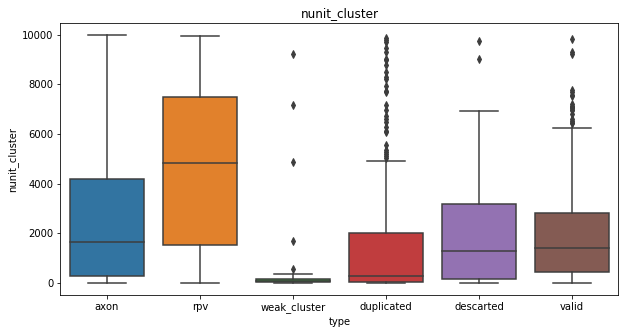

In [8]:
box_plot(x="type", y="nunit_cluster", data=class_type,)

##  Boxplot rvp

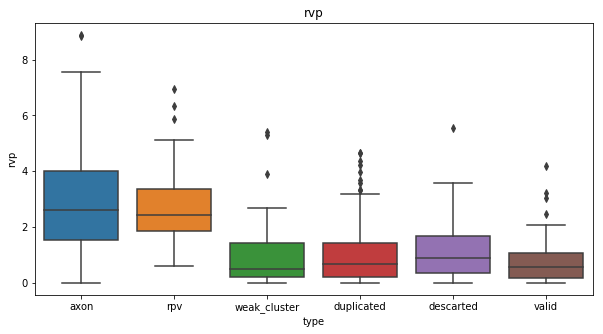

In [9]:
box_plot(x="type", y="rvp", data=class_type,)

##  Boxplot amp_spk_avg

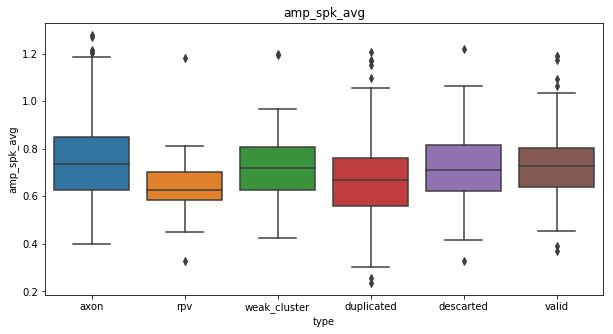

In [10]:
box_plot(x="type", y="amp_spk_avg", data=class_type,)

##  Boxplot spk_rate

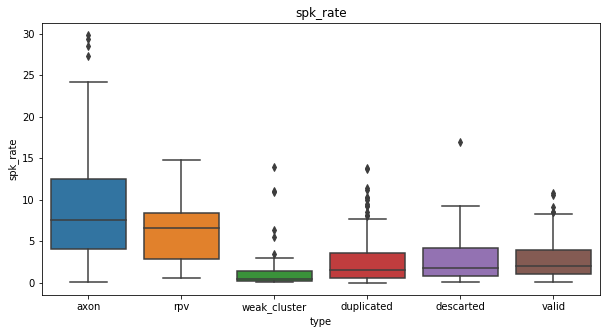

In [11]:
box_plot(x="type", y="spk_rate", data=class_type,)

##  Boxplot rvp

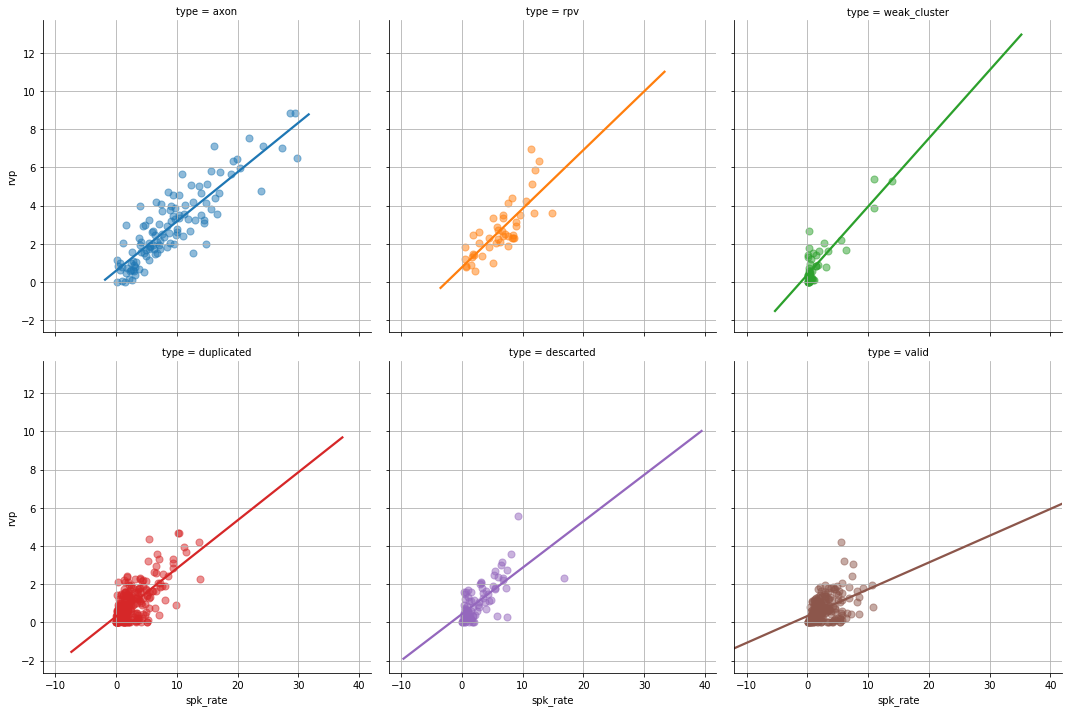

In [12]:
g = sns.lmplot(x='spk_rate', y='rvp', col='type',
           hue='type',  col_wrap=3, ci=None,
           scatter_kws={"s": 50, "alpha": .5},
           data=class_type)
for kax in g.axes:
    kax.grid(True)
g.savefig('../reports/fig/sorting_features/lmplot_spt_rate_vs_rvp.png')